# Demo for Connectivity Optimization with Undirected Graph

## 1 Experimental Setup

Predefined graph: 6-nodes, sparse connection with edge weights 0.6

Data generalization according to GRMF: given $\mathbf{y}|\mathbf{x},\mathbf{L}\sim \mathcal{N}(\mathbf{x},\sigma^2\mathbf{I}), \mathbf{x}|\mathbf{L}\sim\mathcal{N}(\mathbf{0},\mathbf{L}^\dagger)$, generate $\mathbf{y}|\mathbf{L}\sim\mathcal{N}(\mathbf{0},\sigma^2\mathbf{I}+\mathbf{L}^\dagger)$

Data number in total: 128

In [ ]:
torch.manual_seed(0)
# Graph design
import torch
import torch.nn as nn
import scipy.sparse as sp
from scipy.sparse.csgraph import laplacian
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph_from_adj(adj, title=None):
    G = nx.from_numpy_array(adj.numpy())
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for (u, v, d) in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    if title is not None:
        plt.title(title)
    plt.show()

def generate_graph_from_edges(num_nodes, edges, weights=None):
    if weights is None:
        weights = torch.ones(len(edges))
    adj = torch.zeros((num_nodes, num_nodes))
    adj[edges[:, 0], edges[:, 1]] = weights
    adj = adj + adj.t()  # make it symmetric
    adj.fill_diagonal_(0)  # remove self-loops
    
    # For visualization only (using scipy sparse)
    draw_graph_from_adj(adj)
    
    return adj

def generate_y(num_nodes, sigma, L, n):
    # Convert L to tensor if it's not already
    L = torch.tensor(L, dtype=torch.float32)
    
    cov = sigma**2 * torch.eye(num_nodes) + torch.pinverse(L)
    # For generating multivariate normal, we need to make sure covariance is symmetric
    cov = (cov + cov.t()) / 2
    
    # Generate multivariate normal samples
    y = torch.distributions.MultivariateNormal(
        loc=torch.zeros(num_nodes),
        covariance_matrix=cov
    ).sample((n,))
    
    return y


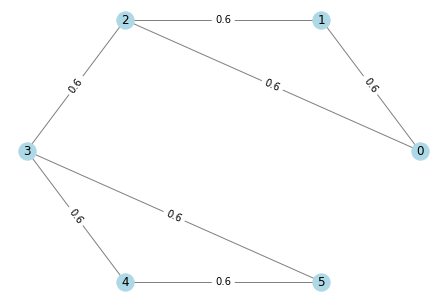

[[ 1.2       -0.6       -0.6       -0.        -0.        -0.       ]
 [-0.6        1.2       -0.6       -0.        -0.        -0.       ]
 [-0.6       -0.6        1.8000001 -0.6       -0.        -0.       ]
 [-0.        -0.        -0.6        1.8000001 -0.6       -0.6      ]
 [-0.        -0.        -0.        -0.6        1.2       -0.6      ]
 [-0.        -0.        -0.        -0.6       -0.6        1.2      ]]


In [17]:
edges = [[0,1],[0,2],[1,2],[2,3],[3,4],[4,5],[3,5]]
edges = torch.tensor(edges)
weights = torch.tensor([0.6]*len(edges))
num_nodes = 6
adj = generate_graph_from_edges(num_nodes, edges, weights)
L = laplacian(adj, normed=False)
print(L)
# generate data
sigma = 0.1
mu = sigma ** 2
n = 128
y = generate_y(num_nodes, sigma, L, n)

## 2 Graph Learning Module (Simple)

- Define a *learnable* embedding for each node, the embedded signals $\tilde{\mathbf{x}}_i = [x_i;\mathbf{e}_i]$
- Feature extraction: A single linear layer with activation `LeakyReLU(0.2)`: $\mathbf{f}_i = \sigma(\mathbf{H}\tilde{\mathbf{x}}_i+\mathbf{h})$
- Weight calculation: $w_{i,j}=\alpha\exp(-\Vert \mathbf{f}_i - \mathbf{f}_j \Vert_2^2)$
- Laplacian matrix: $\mathbf{L}=\text{diag}(\mathbf{W1})-\mathbf{W}$

Parameters: $\Theta=(\{\mathbf{e}_i\}_{i=1}^{N}, \mathbf{H},\mathbf{h})$

In [26]:
class GraphLearningModule(nn.Module):
    # generate weight matrix from node embeddings
    def __init__(self, num_nodes, emb_dim=6, feature_dim=3, alpha=1.0, c=8):
        super(GraphLearningModule, self).__init__()
        self.num_nodes = num_nodes
        # embedding vectors
        self.node_embeddings = nn.Parameter(torch.randn(num_nodes, emb_dim))  # emb_dim-dimensional embeddings
        self.fc = nn.Linear(emb_dim, feature_dim)
        self.leakyrelu = nn.LeakyReLU(0.2)
        # self.alpha = alpha # scaling factor by calculation
        self.c = c

    # def scale_alpha(self, adj):
    #     # scale alpha such that norm(alpha * adj) = c
    #     current_norm = torch.norm(self.alpha * adj)
    #     print('current norm', current_norm)
    #     scaling_factor = self.c / current_norm**2 if current_norm != 0 else 1
    #     self.alpha *= scaling_factor
    #     return scaling_factor

    def forward(self, x):
        # x: (batch_size, num_nodes)
        B = x.size(0)
        # embed each node
        # Expand node_embeddings to batch dimension and add directly to x
        e = x.unsqueeze(-1) + self.node_embeddings.unsqueeze(0) # in shape (B, N, emb_dim)
        f = self.leakyrelu(self.fc(e)) # in shape (B, N, feature_dim)
        df = f.unsqueeze(2) - f.unsqueeze(1) # in shape (B, N, N, feature_dim)
        # dis = torch.norm(df, dim=-1)
        adj = self.alpha * torch.exp(-(df**2).sum(-1)).mean(0) # in shape (N, N)
        adj.fill_diagonal_(0)
        # print('adj before scaling', adj, adj.norm()**2, self.alpha)
        # scaling_factor = self.scale_alpha(adj)
        # print('scale', scaling_factor)
        # adj = adj * scaling_factor
        # print(self.alpha)
        return adj
    
glm = GraphLearningModule(num_nodes)
adj_learned = glm(y)
print("Learned adjacency matrix:")
print(adj_learned, adj_learned.norm()**2)

adj before scaling tensor([[0.0000, 0.4646, 0.4044, 0.5639, 0.4095, 0.5282],
        [0.4646, 0.0000, 0.5858, 0.5224, 0.6635, 0.4352],
        [0.4044, 0.5858, 0.0000, 0.5380, 0.6108, 0.4330],
        [0.5639, 0.5224, 0.5380, 0.0000, 0.4994, 0.5809],
        [0.4095, 0.6635, 0.6108, 0.4994, 0.0000, 0.4148],
        [0.5282, 0.4352, 0.4330, 0.5809, 0.4148, 0.0000]],
       grad_fn=<CopySlices>) tensor(7.9975, grad_fn=<PowBackward0>) 1.0
current norm tensor(2.8280, grad_fn=<CopyBackwards>)
scale tensor(1.0003, grad_fn=<MulBackward0>)
tensor(1.0003, grad_fn=<MulBackward0>)
Learned adjacency matrix:
tensor([[0.0000, 0.4648, 0.4046, 0.5641, 0.4097, 0.5283],
        [0.4648, 0.0000, 0.5860, 0.5225, 0.6637, 0.4354],
        [0.4046, 0.5860, 0.0000, 0.5382, 0.6110, 0.4332],
        [0.5641, 0.5225, 0.5382, 0.0000, 0.4996, 0.5811],
        [0.4097, 0.6637, 0.6110, 0.4996, 0.0000, 0.4150],
        [0.5283, 0.4354, 0.4332, 0.5811, 0.4150, 0.0000]],
       grad_fn=<MulBackward0>) tensor(8.0025, gr

## 3 GEM Algorithm
### 3.1 Hard E-step: Update $\mathbf{x}$
$$
\min_x \Vert \mathbf{y}-\mathbf{x}\Vert_2^2 + \mu \mathbf{x}^\top\mathbf{Lx}\\
\mathbf{x}^*=(\mathbf{I}+\mu\mathbf{L})^{-1}\mathbf{y}
$$
In practice, solve in CG

Update graph with new $\mathbf{x}$ and project it to the sphere
### 3.2 M-step-1: update graph weights $\Theta$
$$
\min_\Theta \mathbf{x}^\top\mathbf{Lx} \quad \text{s.t. }~ \Vert \mathbf{W}\circ\mathbf{S} \Vert_2^2=c
$$
Projected Gradient Method:
1. Gradient step: $\Theta^{t+1} = \Theta^{t} - \delta^{t}\nabla_\Theta(\mathbf{x}^\top\mathbf{L^tx})$
2. Recompute graph: $\mathbf{W}^{t+1} = \mathbf{W}(\Theta^{t+1})$
3. Project to the sphere: $\alpha \leftarrow \frac{\sqrt{c}}{\Vert \mathbf{W}^{t+1} \Vert_F} \alpha$
### 3.3 M-step-2 update graph connectivity $\mathbf{S}$
$$
\min_{\mathbf{S}\in\{0,1\}^{N\times N}} \mathbf{x}^\top\mathbf{Lx} + \gamma \Vert \mathbf{S}\Vert_{0,\text{off}}
$$
Greedy approach:
1. Sort $Q_{i,j} = \frac{1}{2W_{i,j}}(x_i-x_j)^2+\frac{\gamma}{W_{i,j}^2}$ in ascending order $\iff$ Sort $Q'_{i,j}=W_{i,j}^2 / [\frac{1}{2}W_{i,j}(x_i-x_j)^2 + \gamma]$ in descending order (to avoid division by zeros)
2. Select edges according to ascending $Q$ until reaches $\Vert\mathbf{W}\Vert_F^2=c$.

In [ ]:
import math
def Laplacian_from_adj(adj):
    D = torch.diag(adj.sum(1))
    L = D - adj
    return L

def GLR(x, L):
    # x in shape (B, N), L in shape (N, N)
    # return torch.trace(x @ L @ x.t()) / x.size(0) # in shape (B, N)
    return torch.trace(x.t() @ L @ x) / x.size(0) # in shape (B, N)

class GEM(nn.Module):
    def __init__(self, num_nodes, mu, gamma, step_size, emb_dim=6, feature_dim=3, alpha=1.0, c=8):
        super(GEM, self).__init__()
        self.glm = GraphLearningModule(num_nodes, emb_dim, feature_dim, alpha, c)
        # self.S = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)  # all-one matrix with zero diagonal
        self.mu = mu
        self.alpha = alpha
        self.c = c
        self.step_size = step_size
        self.gamma = gamma
    
    def scale_W(self, adj, S):
        W = adj * S
        return math.sqrt(self.c) * W / W.norm() if W.norm() != 0 else W
    
    def E_step(self, y, W):
        # y in (B, N)
        B = y.size(0)
        D = torch.diag(W.sum(1))
        L = D - W
        cov = torch.eye(self.glm.num_nodes) + self.mu * L
        return torch.linalg.solve(cov, y.t()).t()  # return in shape (B, N)
    
    def M_step_1(self, x, L):
        loss = GLR(x, L)
        # backward to gradient descent
        grads = torch.autograd.grad(loss, self.glm.parameters(), retain_graph=True, create_graph=True)
        with torch.no_grad():
            for param, grad in zip(self.glm.parameters(), grads):
                param.sub_(self.step_size * grad)
        # if use meta-learning in unrolling model, needs further treatment
        return None
    
    def M_step_2(self, x, W):
        # optimize alpha with gradient descent
        dis_x = x.unsqueeze(2) - x.unsqueeze(1) # in shape (B, N, N)
        dis_x_2 = (dis_x**2).mean(0) # in shape (N, N)
        # calculate Q_inv and sort in an descending order
        Q = W ** 2 / (dis_x_2 * W / 2 + self.gamma)  # in shape (N, N)
        Q_sorted, Q_indices = torch.sort(Q.view(-1), descending=True)
        # select edges until norm(W*S) <= c
        W_flatten = W.view(-1)
        S_flatten = torch.zeros_like(Q).view(-1)
        sum_squared_W = 0
        idx = 0
        while sum_squared_W < self.c and idx < len(Q_sorted):
            current_idx = Q_indices[idx]
            S_flatten[current_idx] = 1
            sum_squared_W += W_flatten[current_idx] ** 2
            idx += 1
        S = S_flatten.view(self.glm.num_nodes, self.glm.num_nodes)
        S = ((S + S.t()) > 0).float() # make symmetric
        S.fill_diagonal_(0)  # remove self-loops
        return S
    # needs to be further simplified to be more efficient


    def single_step(self, y, adj, S):
        # y in (B, N)
        B = y.size(0)
        W = self.scale_W(adj, S)

        # E-step
        x = self.E_step(y, W)
        # recompute graph
        adj = self.glm(x) # unregularized adjacency
        W = self.scale_W(adj, S)  # element-wise product to enforce sparsity pattern
        L = torch.diag(W.sum(1)) - W
        print(f'after E-step: delta_W norm {torch.norm(W - adj_learned):.4f}, GLR {GLR(x, L):.4f}')

        # M-step-1: minimize GLR
        self.M_step_1(x, L) # update parameters in glm
        adj = self.glm(x) # unregularized adjacency
        W = self.scale_W(adj, S)  # element-wise product to enforce sparsity pattern
        L = torch.diag(W.sum(1)) - W
        print(f'after M-step-1: delta_W norm {torch.norm(W - adj_learned):.4f}, GLR {GLR(x, L):.4f}')

        # M-step-2: optimizing alpha with gradient steps
        S = self.M_step_2(x, W)
        return x, adj, S
    
    def forward(self, y, adj_init, S_init, num_iters=10):
        adj = adj_init
        S = S_init
        
        for it in range(num_iters):
            print(f'Iteration {it+1}/{num_iters}')
            x, adj, S = self.single_step(y, adj, S)
            W = adj * S
            draw_graph_from_adj(W.detach().cpu(), title=f'Learned Graph at Iteration {it+1}')
        return x, adj, S